In [3]:
import os
import time
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge, Input

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

In [4]:
def double_integrate(df, col):
    df.sort_values(by='t', inplace=True)
    velocities = df[col].cumsum()
    positions = velocities.cumsum()
    return positions
# load data
def load_data_time(directory = 'data/group3/config_1', all_data=[], labels=[]):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        data = pd.read_csv(f)
        data['pos_x'] = double_integrate(data,'raw_acceleration_x')
        data['pos_y'] = double_integrate(data,'raw_acceleration_y')
        data['pos_z'] = double_integrate(data,'raw_acceleration_z')
        all_data.append(np.array(data))
        # formatage des labels pour chaque pas de temps
        if directory == 'data/h_config1-lcb':
            _label = int(filename[2])
        elif directory == 'data/v_config1-lcb':
            _label = int(filename[10])
        elif directory == 'data/groupe1_groupe2':
            _label = int(filename.split('_')[1])
        else :
            _label = int(filename[0])
        labels.append(np.array([_label]*len(data)).reshape(-1,1))
    columns_name = pd.read_csv(os.path.join(directory, os.listdir(directory)[1])).columns.tolist()
    return all_data, labels, columns_name

# load horizontal
# all_data, labels, _ = load_data_time()
# print(len(all_data))
all_data, labels, _ = load_data_time('data/h_config1-lcb')#,all_data,labels)
# print(len(all_data))
# # load vertical
# all_data, labels, _ = load_data_time('data/v_config1-lcb',all_data,labels)
# print(len(all_data))
# # load 3D
# all_data, labels, _ = load_data_time('data/groupe1_groupe2',all_data,labels)
# print(len(all_data))

In [5]:
enc = OneHotEncoder()
enc.fit_transform(np.array(np.arange(10).reshape(-1,1)))

new_label=[]
for i in range(len(all_data)):
    new_label.append(enc.transform(labels[i]).toarray())#np.tile(enc.transform(labels[i]), (len(all_data[i]), 1)))
print("On transforme les label en one hot encoded:\n",new_label[0][:10])

On transforme les label en one hot encoded:
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [6]:
def train_test_split(all_data, labels, seed_=42):
    np.random.seed(seed_)
    idx_per_class={}
    for i, target in enumerate(labels):
        for j in range(10):
            if j == int(target[0][0]):
                if j not in idx_per_class:
                    idx_per_class[j] = str(i)
                else:
                    idx_per_class[j] = str(idx_per_class[j])+'-'+str(i)

    idx_test=[]
    for t_ in idx_per_class.keys():
        list_idx = idx_per_class[t_].split('-')
        n_test = len(list_idx)//4  # 25% dans le test
        idx_test.append(np.random.choice(list_idx, n_test))

    idx_test = np.concatenate(idx_test).astype(int)
    idx_train = np.array( list(set(np.arange(len(all_data))) - set(idx_test))).astype(int)

    X_train, X_test = [all_data[i] for i in idx_train],  [all_data[i] for i in idx_test] 
    y_train, y_test = [new_label[i] for i in idx_train],  [new_label[i] for i in idx_test]
    return X_train, X_test, y_train, y_test

In [7]:
def make_binary(arr):
    mask = np.zeros(arr.shape)
    mask[np.argmax(arr)] = 1
    return mask

def most_occuring_pred(arr):
    idx = np.argmax(sum(arr))
    mask = np.zeros(arr[0].shape)
    mask[idx] = 1
    mask = mask.reshape(1, -1)
    return enc.inverse_transform(mask)[0]

In [8]:
def cross_validate(model, all_data, labels, folds_=5):
    # cross validation
    results = []
    for cv in np.arange(folds_)+1:
        seed = np.random.randint(99)
        X_train, X_test, y_train, y_test = train_test_split(all_data, labels, seed_=seed)
        
        # fit
        t0=time.time()
        model = model.fit(X_train, y_train, stateful=False, warmup=2)
        time_fit = time.time() - t0

        # pred
        Y_pred = model.run(X_test, stateful=False)
        time_pred = time.time()-t0-time_fit

        Y_pred_class = [most_occuring_pred([make_binary(b) for b in a]) for a in Y_pred] 
        Y_test_class = [most_occuring_pred(a) for a in y_test] 

        # train 
        Y_pred_train = model.run(X_train, stateful=False)

        Y_pred_class_tr = [most_occuring_pred([make_binary(b) for b in a]) for a in Y_pred_train] 
        Y_test_class_tr = [most_occuring_pred(a) for a in y_train] 

        # compute score
        score = accuracy_score(Y_pred_class,Y_test_class)
        score_train = accuracy_score(Y_pred_class_tr,Y_test_class_tr)
        results.append([cv,score,score_train,time_fit,time_pred])
    return results

In [9]:
# on initialize reservoirpy
rpy.verbosity(0) 
rpy.set_seed(42) 

# Simpliest ESN model 
# https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/1-Getting_Started.ipynb
reservoir = Reservoir(300, lr=0.1, sr=0.9)
ridge = Ridge(ridge=1e-6)
model = reservoir >> ridge

results = cross_validate(model, all_data, labels, folds_=5)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Resultats:
 cv             3.000000
test_score     0.814085
score_train    0.965041
fit_time       3.190940
pred_time      0.612767
dtype: float64


Text(0.5, 1.0, 'Cross validation score')

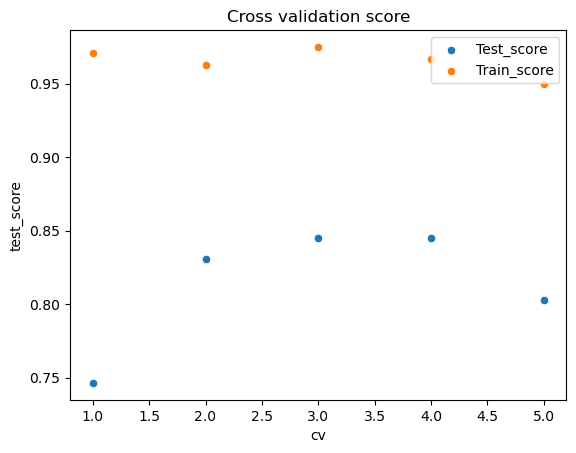

In [10]:
res_ = pd.DataFrame(results, columns=['cv','test_score','score_train','fit_time','pred_time'])
print("Resultats:\n",res_.mean())
import seaborn as sns
sns.scatterplot(data=res_,x='cv',y='test_score')
sns.scatterplot(data=res_,x='cv',y='score_train')
plt.legend(['Test_score','Train_score'])
plt.title('Cross validation score')

In [11]:
# Define the model
source = Input()
reservoir = Reservoir(300, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-6)
model = [source >> reservoir, source] >> readout 

# calculate
results = cross_validate(model, all_data, labels, folds_=5)
res_ = pd.DataFrame(results, columns=['cv','test_score','score_train','fit_time','pred_time'])
print("Resultats:\n",res_.mean())

# plot results
sns.scatterplot(data=res_,x='cv',y='test_score')
sns.scatterplot(data=res_,x='cv',y='score_train')
plt.legend(['Test_score','Train_score'])
plt.title('Cross validation score')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.2753e-26): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'Cross validation score')

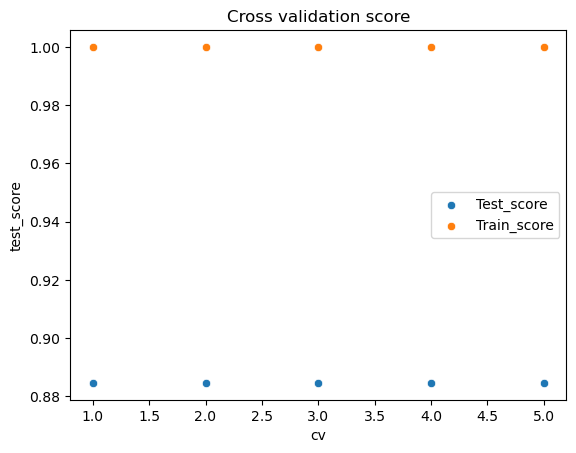

In [ ]:
#Hierarchical ESN 
reservoir1 = Reservoir(300,  sr=0.9, lr=0.1, name="res1_1")
reservoir2 = Reservoir(300, sr=0.9, lr=0.1, name="res2_1")

readout1 = Ridge(ridge=1e-5, name="readout1_1")
readout2 = Ridge(ridge=1e-5, name="readout2_1")

model = reservoir1 >> readout1 >> reservoir2 >> readout2

# calculate
results = cross_validate(model, all_data, labels, folds_=5)
res_ = pd.DataFrame(results, columns=['cv','test_score','score_train','fit_time','pred_time'])
print("Resultats:\n",res_.mean())

# plot results
sns.scatterplot(data=res_,x='cv',y='test_score')
sns.scatterplot(data=res_,x='cv',y='score_train')
plt.legend(['Test_score','Train_score'])
plt.title('Cross validation score')

In [ ]:
#Deep ESN
reservoir1 = Reservoir(100, name="res1-2")
reservoir2 = Reservoir(100, name="res2-2")
reservoir3 = Reservoir(100, name="res3-2")

readout = Ridge(name="readout-2")

model = reservoir1 >> reservoir2 >> reservoir3 & \
        data >> [reservoir1, reservoir2, reservoir3] >> readout

In [ ]:
#Multi input
reservoir1 = Reservoir(100, name="res1-3")
reservoir2 = Reservoir(100, name="res2-3")
reservoir3 = Reservoir(100, name="res3-3")

readout1 = Ridge(name="readout2")
readout2 = Ridge(name="readout1")

model = [reservoir1, reservoir2] >> readout1 & \
        [reservoir2, reservoir3] >> readout2